In [1]:
import random
import re

import pandas as pd
import pytorch_lightning as pl

from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt

from freestyl.dataset.dataframe_wrapper import DataframeWrapper
from freestyl.supervised.siamese import train_dataframewrappers, get_df_prediction
from freestyl.supervised.siamese.utils import score_from_preds, find_index_of_first_change
from freestyl.utils import plot_aucroc_curve
#>>> x = [1, 2, 3, 4, 5, 6]
#>>> .shuffle(x)

NEW_DATASET = False
SPLIT_ON_AUTHORS = False
USE_POS = True
USE_TRIG = True
USE_FW = True
LR = 1e-4
BATCH = 64
DROPOUT = .3
LOSS = "stn_contrastive"
CHRYSOSTOM = True
SAMPLE = 2
DYDIMUS = True
COMMENT = False
DEV_MINER = True
SPLIT = False
ISDIST = "linear" not in LOSS
METRICKEY = "Probability" if not ISDIST else "Distance"

if SPLIT:
    SIZE = (32, 32, 32)
elif USE_POS and not USE_FW:
    SIZE = 50
elif USE_POS and USE_FW:
    SIZE = 64
else:
    SIZE = 64
    
seed = 42
IGNORE_KEYS = [
    "file", "author", "textgroup", "title", "tokens", "length", "modified_text"
]
REMOVED = ["Euclides"]


def make_file_name(filename: str) -> str:
    *x, y = filename.split(".")
    x = ".".join(x)
    *dirs, x = x.split("/")
    dirs = "/".join(dirs)
    print()
    name = f"TRI[{USE_TRIG}]B[{BATCH}]Do[{DROPOUT}]Min[{DEV_MINER}]Split[{SPLIT}]Pos[{USE_POS}]FW[{USE_FW}]LR[{LR}]SIZE[{SIZE}]LOSS[{LOSS}]CHRYS[{CHRYSOSTOM}]DYD[{DYDIMUS}]SAMPLE[{SAMPLE}]COMMENT[{COMMENT}].{x}.{y}"
    if dirs:
        return f"{dirs}/{name}"
    return name
    

/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator12recordStreamERKNS_7DataPtrENS0_10CUDAStreamE
  warn(f"Failed to load image Python extension: {e}")
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in 

## Import Data

In [2]:
def get_train_dev_test(filtre, seed=42, ratio=10):
    test = len(filtre) * ratio // 100
    dev_and_test = test * 2
    print(f"Train categorical samples: {len(filtre)-dev_and_test}")
    print(f"Dev   categorical samples: {dev_and_test-test}")
    print(f"Test  categorical samples: {test}")
    r = random.Random(seed)
    r.shuffle(filtre)
    return filtre[:-dev_and_test], filtre[-dev_and_test:-test], filtre[-test:]


if NEW_DATASET:
    df = pd.read_csv("tlg-features.csv").sample(frac=1)
    #df = df[df.tokens >= 5000]
    #print(">= 5000", df.shape)
    #df = df[~df.file.isin(POETRY)]
    #print(">= Poetry", df.shape)
    # df = df[~df.title.str.contains("Dub\.|Sp\.|Fragm|Excerpt|(e cod\.)|Suda|recensio|fragm|sp\.|dub\.|(fort\. auctore)|Scholia")]
    print("Title filter", df.shape)
    #df = df[~df["full-pos-text"].isna()]
    #print(">= POS missing", df.shape)
    
    # Filter based on authors, to generalize better. Everything should be out of domain\
    train, dev, test = [], [], []
    if SPLIT_ON_AUTHORS:
        authors = df.author.value_counts()
        a, b, c = get_train_dev_test(authors[authors > 1].index.tolist())
    else:
        a, b, c = get_train_dev_test(df.title.unique().tolist())
        
    train.extend(a)
    dev.extend(b)
    test.extend(c)
    
#     a, b, c = get_train_dev_test(authors[authors == 1].index.tolist())
#     train.extend(a)
#     dev.extend(b)
#     test.extend(c)

    if SPLIT_ON_AUTHORS:
        train = df[df.author.isin(train)].copy(deep=True)
        dev = df[df.author.isin(dev)].copy(deep=True)#.author.value_counts()
        test = df[df.author.isin(test)].copy(deep=True)#.author.value_counts()
    else:
        train = df[df.title.isin(train)].copy(deep=True)
        dev = df[df.title.isin(dev)].copy(deep=True)#.author.value_counts()
        test = df[df.title.isin(test)].copy(deep=True)#.author.value_counts()
        
    train.to_csv("tlg-train.csv", index=False)
    dev.to_csv("tlg-dev.csv", index=False)
    test.to_csv("tlg-test.csv", index=False)
else:
    train = pd.read_csv("tlg-train.csv")
    dev = pd.read_csv("tlg-dev.csv")
    test = pd.read_csv("tlg-test.csv")
    
train = train[~train.author.isin(REMOVED)]
dev = dev[~dev.author.isin(REMOVED)]
test = test[~test.author.isin(REMOVED)]

if not CHRYSOSTOM:
    train = train[~train.author.str.contains("Chrysosto")]
    dev = dev[~dev.author.str.contains("Chrysosto")]
    test = test[~test.author.str.contains("Chrysosto")]
    
if not DYDIMUS:
    train = train[~train.author.str.contains("Didym")]
    dev = dev[~dev.author.str.contains("Didym")]
    test = test[~test.author.str.contains("Didym")]
    
if not COMMENT:
    train = train[~train.title.str.contains("Comment")]
    dev = dev[~dev.title.str.contains("Comment")]
    test = test[~test.title.str.contains("Comment")]

print(f"Train Shape : {train.shape}")
print(f"Dev Shape : {dev.shape}")
print(f"Test Shape : {test.shape}")

Train Shape : (1681, 2108)
Dev Shape : (174, 2108)
Test Shape : (216, 2107)


In [3]:
train.title.str.contains("Comment").value_counts()
test.title.str.contains("Comment").value_counts()

False    216
Name: title, dtype: int64

In [4]:
train.title.unique().shape

(496,)

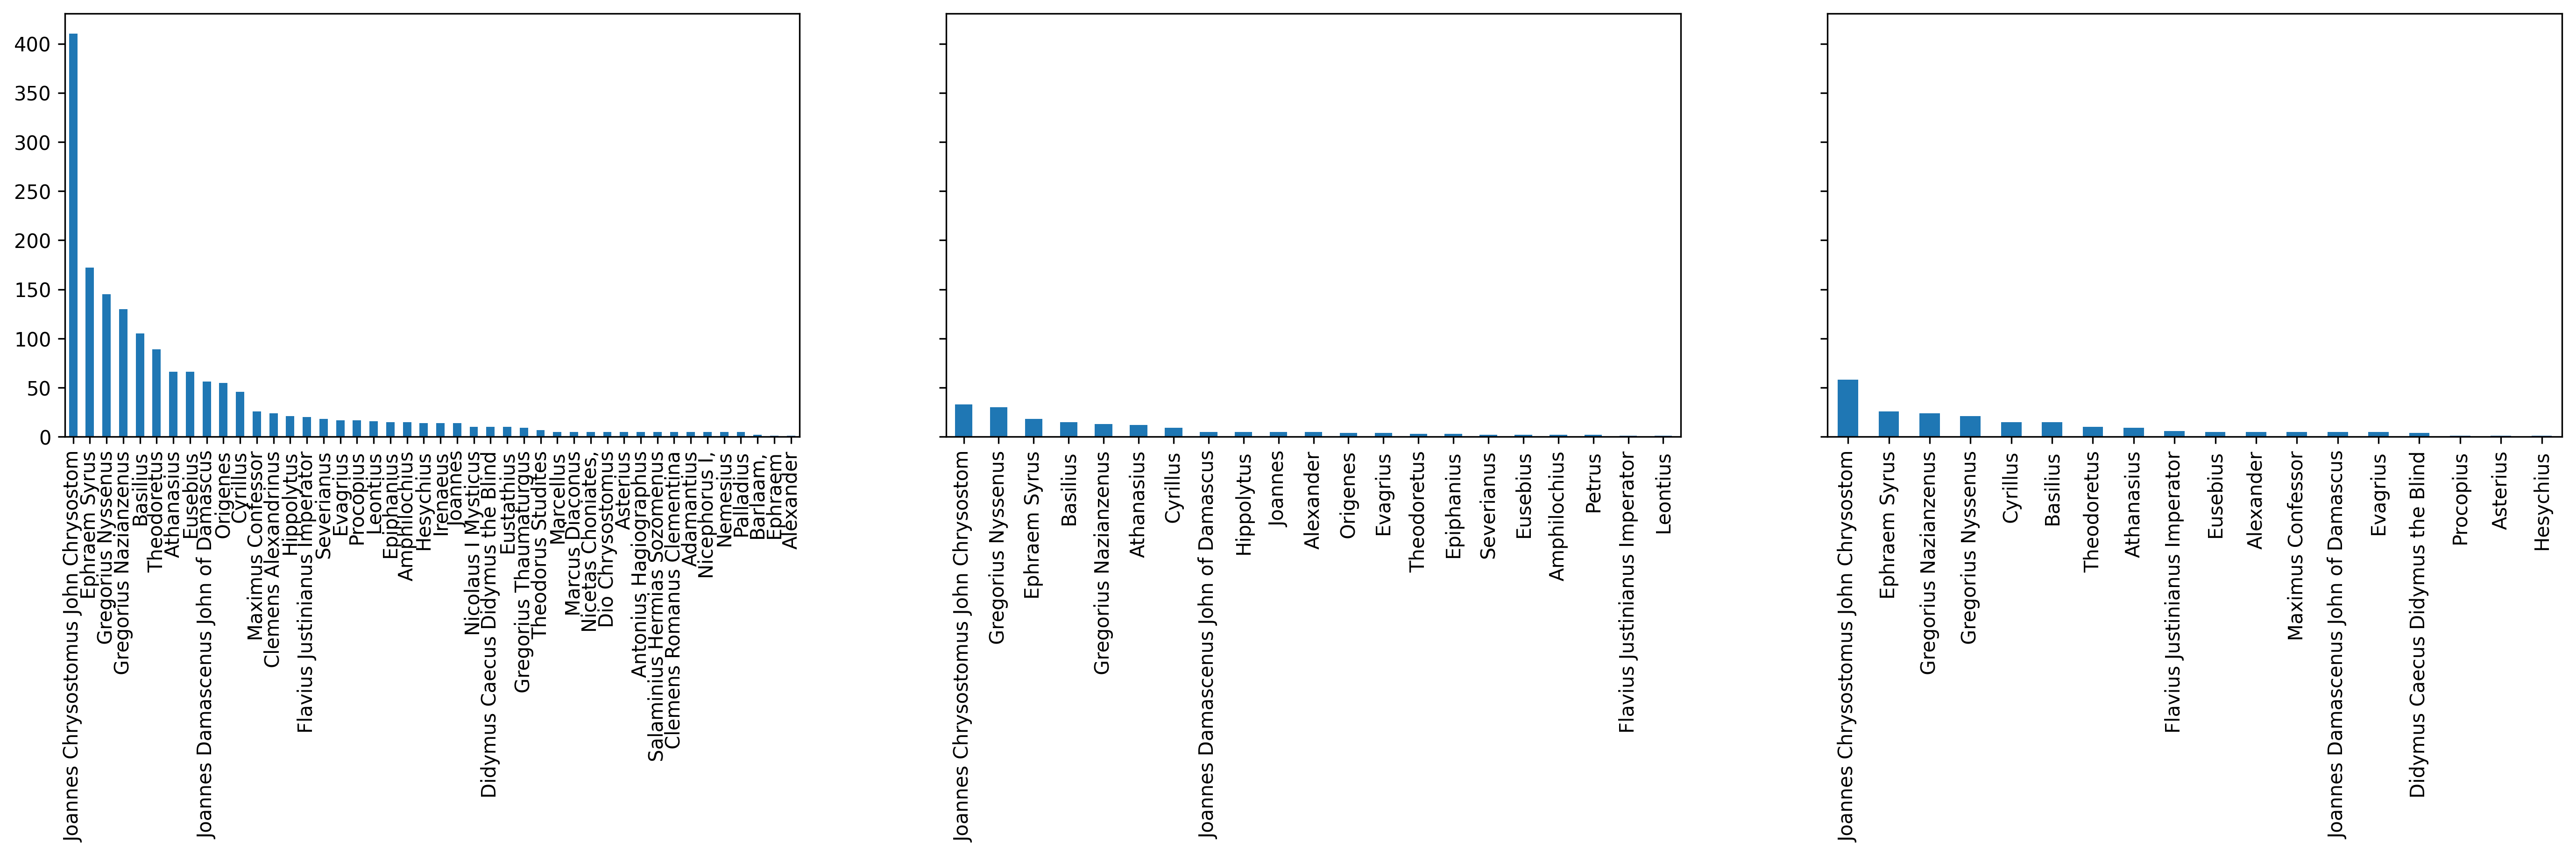

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, dpi=300, figsize = (23, 4), sharey=True)
train.author.value_counts().plot.bar(ax=ax1)
dev.author.value_counts().plot.bar(ax=ax2)
test.author.value_counts().plot.bar(ax=ax3)
fig.savefig(make_file_name("samples.png"))

## Util functions

In [6]:
def assign_normalization(dfw):
    dfw.normalized._dataframe = dfw.dataframe.fillna(0)
    
def get_scores(scores, distance: float, col=METRICKEY, noprint=False) -> None:

    if "distance" in col.lower():
        scores["Attribution"] = scores[col] <= distance
    else:
        scores["Attribution"] = scores[col] >= distance
    
    pos = scores[scores.IsAPair].Attribution.value_counts().to_dict()
    negs = scores[~scores.IsAPair].Attribution.value_counts().to_dict()
    
    tp = pos.get(True, 0)
    fn = pos.get(False, 0)
    fp = negs.get(True, 0)
    tn = negs.get(False, 0)
    
    if noprint is False:
        print(f"True positives: {tp}\nFalse Negative {fn}")
        print(f"True Negative {tn}")
        print(f"False positives: {fp}\nAccuracy: {tp/(fn+tp):.2f}")
    return tp, fp, tn, fn

## Automatically retrieve some constant parameters

In [7]:
POS_COLS = [
    col
    for col in train.columns
    if col.startswith("$POS$")
]
FW_COLS = [
    col
    for col in train.columns
    if col.startswith("$MFW$")
]
TRIG_COLS = [
    col
    for col in train.columns
    if col.startswith("$TRI$")
]
KEEP = [] + (
    POS_COLS if USE_POS else []
) + (
    FW_COLS if USE_FW else []
) + (
    TRIG_COLS if USE_TRIG else []
)
IGNORE = [
    col for col in train.columns
    if col not in KEEP
]

print(IGNORE_KEYS)

['file', 'author', 'textgroup', 'title', 'tokens', 'length', 'modified_text']


## Get DataFrameWrapper

In [8]:
data = DataframeWrapper(train, target="author", label=["author", "title"], x_ignore=IGNORE)
assign_normalization(data)
data_dev = DataframeWrapper(dev, target="author", label=["author", "title"], x_ignore=IGNORE)
data_dev.update_features(data.features)
assign_normalization(data_dev)
data_test = DataframeWrapper(test, target="author", label=["author", "title"], x_ignore=IGNORE)
data_test.update_features(data.features)
assign_normalization(data_test)
data._x_ignore

('Unnamed: 0',
 'file',
 'author',
 'title',
 'textgroup',
 'tokens',
 'length',
 'modified_text')

## CHecking some details

In [9]:
data.normalized.xs.head()

,$POS$v-n-v,$POS$v-c-d,$POS$d-l-n,$POS$l-n-n,$POS$d-n-v,$POS$n-v-l,$POS$l-l-n,$POS$n-n-v,$POS$n-v-n,$POS$n-v-r,...,$TRI$σῶμ,$TRI$οἷο,$TRI$λῳ_,$TRI$_ἤγ,$TRI$ἁπλ,$TRI$_λύ,$TRI$ἐνδ,$TRI$_λυ,$TRI$λεγ,$TRI$εἴρ
0,0.001786,0.010714,0.012500,0.017857,0.010714,0.017857,0.008929,0.008929,0.003571,0.014286,...,0.000268,0.000000,0.000268,0.000000,0.000268,0.000268,0.000268,0.000000,0.000000,0.000000
2,0.001980,0.007921,0.009901,0.013861,0.009901,0.027723,0.013861,0.011881,0.015842,0.001980,...,0.000000,0.000000,0.000000,0.000000,0.000268,0.000268,0.000000,0.000000,0.000000,0.000268
3,0.002519,0.005038,0.015113,0.015113,0.002519,0.022670,0.005038,0.002519,0.007557,0.000000,...,0.000000,0.000279,0.000279,0.000000,0.000279,0.000000,0.000279,0.000000,0.000000,0.000000
5,0.007018,0.001754,0.010526,0.021053,0.001754,0.024561,0.001754,0.012281,0.001754,0.010526,...,0.000279,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000558,0.001116,0.000000
6,0.000000,0.003992,0.007984,0.021956,0.000000,0.017964,0.009980,0.013972,0.003992,0.011976,...,0.000000,0.000000,0.000000,0.000278,0.000000,0.000000,0.000000,0.000000,0.000555,0.000000


## Training

In [10]:
models, train_trainer = train_dataframewrappers(
    train=data,
    dev=data_dev,
    test=data_test,
    optim="Adam",
    accelerator="gpu",
    # 2e-5, Batch 32
    learning_rate=LR,
    margin=1,
    dimension=SIZE,
    loss=LOSS,
    pos_strategy="easy",
    neg_strategy="semihard",
    sample=SAMPLE,
    batch_size=BATCH,
    gpus=1,
    dropout=DROPOUT,
    min_epochs=100,
    miner_for_dev=DEV_MINER,
    split_dim=find_index_of_first_change(data.features) if SPLIT else None,
    patience=20
    #loss="triplet"
)


/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
Missing logger folder: /home/thibault/dev/Chryso-Voicu/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                              | Params
----------------------------------------------------------------
0 | aucroc    | AUROC                             | 0     
1 | distance  | SNRDistance 

Sanity Checking: 0it [00:00, ?it/s]

/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (27) is sm

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but the required `min_epochs=100` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [11]:
models.eval()

In [12]:
#pd.DataFrame({key:val for key, val in train_trainer.logger.history.items() if len(val) > 1})

### Get first FP distance

In [13]:
trainer = pl.Trainer(
    gpus=1,
    accelerator="gpu"
)
scores = get_df_prediction(trainer, model=models, compared=data)
#scores
print(f"ROC: {roc_auc_score(scores.IsAPair, scores.Probability)}")

In [14]:
scores[~scores.IsAPair].sort_values("Distance").head()

## Evaluating Dev for Test Threshold

In [15]:
trainer = pl.Trainer(
    gpus=1,
    accelerator="gpu"
)
dev_pairs = get_df_prediction(trainer, model=models, compared=data_dev)
#scores
print(f"ROC: {roc_auc_score(dev_pairs.IsAPair, dev_pairs.Probability)}")

In [16]:
dev_pairs[~dev_pairs.IsAPair].sort_values("Distance").head()

In [17]:
dev_pairs.Distance.plot.box()

In [18]:
#clip = scores.Distance.apply(lambda x: 2 if x > 2 else x)
#scores.Distance = clip

## Study AUCROC

In [19]:
plot_aucroc_curve(dev_pairs.IsAPair, dev_pairs[METRICKEY], nth=100, is_dist=ISDIST)
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.gcf().savefig(make_file_name("aucroc-dev.png"))

In [20]:
for cls in dev_pairs.ComparedClass.unique():
    plt.figure()
    sns.boxplot(data=dev_pairs[(dev_pairs.ComparedClass==cls)], x="IsAPair", y=METRICKEY)
    plt.gca().set_title(cls)
    plt.gcf().savefig(make_file_name(f"Dev-{cls}.png"))
    #scores.groupby("ComparedClass").plot.box(y="Distance", x="IsAPair")

### Find sweet spot

In [21]:
MAX_DISTANCE = 6
get_scores(dev_pairs, MAX_DISTANCE)
print("\n===\nWithout sampling\n===\n")
get_scores(dev_pairs[(dev_pairs.ComparedLabel != dev_pairs.ComparatorLabel)], MAX_DISTANCE)

## Evaluating Test with Dev Threshold

In [22]:
models.eval()
MAX_DISTANCE = 6

test_pairs = get_df_prediction(trainer, model=models, compared=data_test, threshold=MAX_DISTANCE)

In [23]:
test_pairs[~test_pairs.IsAPair].sort_values(METRICKEY).head()

In [24]:
print(f"ROC: {roc_auc_score(test_pairs.IsAPair, test_pairs.Probability)}")
MAX_DISTANCE = 6
get_scores(test_pairs, MAX_DISTANCE)
print("\n===\nWithout sampling\n===\n")
get_scores(test_pairs[(test_pairs.ComparedLabel != test_pairs.ComparatorLabel)], MAX_DISTANCE)

In [25]:
plot_aucroc_curve(test_pairs.IsAPair, test_pairs[METRICKEY], nth=75, is_dist=ISDIST)
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.gcf().savefig(make_file_name("test-aucroc.png"))

In [26]:
dev_pairs.to_csv(make_file_name("test-results.csv"))

## On Voicu !

In [27]:
import regex as re
import json
import unicodedata

df = pd.read_csv("pc-features.csv")
DFW = DataframeWrapper(df, label=("author", "title"), target="title", 
                       x_ignore=[col for col in df.columns if col not in data.features])
#
print(len(DFW.features))
print(len(data.features))
DFW.update_features(data.features)
assign_normalization(DFW)
#DFW._features = data.features
print(len(data.features))
print(len(DFW.features))

In [28]:
models.eval()
pairs = get_df_prediction(
    trainer, model=models, 
    compared=DFW, #comparator=DFW, 
    threshold=MAX_DISTANCE
)
pairs = pairs[pairs.ComparedLabel != pairs.ComparatorLabel]

In [29]:
pairs["ComparedClass"] = pairs.ComparedLabel.apply(lambda x: x.split()[0].strip())
pairs["ComparatorClass"] = pairs.ComparatorLabel.apply(lambda x: x.split()[0].strip())
pairs["IsAPair"] = pairs.ComparedClass == pairs.ComparatorClass
pairs.head()

In [30]:
pairs[f"Rounded{METRICKEY}"] = pairs[METRICKEY].round(3)
dists = sorted(pairs[f"Rounded{METRICKEY}"].unique())

pairs["TestTPR"] = .0
pairs["TestPre"] = .0
pairs["TestFPR"] = 1.0
pairs["TestFP"] = -1
pairs["TestFN"] = -1
pairs["TestTP"] = -1
pairs["TestTN"] = -1
pairs["DevTPR"] = .0
pairs["DevPre"] = .0
pairs["DevFPR"] = 1.0
pairs["DevFP"] = -1
pairs["DevFN"] = -1
pairs["DevTP"] = -1
pairs["DevTN"] = -1

for dist in dists:
    tp, fp, tn, fn = get_scores(test_pairs, dist, col=METRICKEY, noprint=True)
    #print(tp, fp, tn, fn)
    filt = pairs[f"Rounded{METRICKEY}"] == dist
    pairs.loc[filt, "TestTPR"] = tp / max([tp+fn, 1])
    pairs.loc[filt, "TestFPR"] = fp / max([fp+tn, 1])
    pairs.loc[filt, "TestPre"] = tp / max([fp+tp, 1])
    pairs.loc[filt, "TestFP"] = fp
    pairs.loc[filt, "TestTP"] = tp
    pairs.loc[filt, "TestFN"] = fn
    pairs.loc[filt, "TestTN"] = tn
    
    # DEV
    
    tp, fp, tn, fn = get_scores(dev_pairs, dist, col=METRICKEY, noprint=True)
    #print(tp, fp, tn, fn)
    filt = pairs[f"Rounded{METRICKEY}"] == dist
    pairs.loc[filt, "DevTPR"] = tp / max([tp+fn, 1])
    pairs.loc[filt, "DevFPR"] = fp / max([fp+tn, 1])
    pairs.loc[filt, "DevPre"] = tp / max([fp+tp, 1])
    pairs.loc[filt, "DevFP"] = fp
    pairs.loc[filt, "DevTP"] = tp
    pairs.loc[filt, "DevFN"] = fn
    pairs.loc[filt, "DevTN"] = tn
    

In [31]:
pairs.sort_values("DevPre").tail()

In [32]:
pairs.sort_values(["DevPre", "TestPre", "Distance"]).to_csv(make_file_name("pairs-last-experiment.csv"))